# Librerias

In [1]:
import matplotlib.pyplot as plt
from math import pi
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import eig
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import wx

# Tecnicas

### Normalizaciones 

In [2]:
def normalizacionColumna(df, i):
    columns = df.columns.values
    df[columns[i]] = (df[columns[i]] - df[columns[i]].min()) / (df[columns[i]].max() - df[columns[i]].min())

def normalizacionColumnaz(df, i):
    columns = df.columns.values
    df[columns[i]] = (df[columns[i]] - df[columns[i]].mean()) / (df[columns[i]].std(ddof=0))
    
def normalizarDataset(df, indices):
    df = df.copy()
    for i in indices:
        normalizacionColumna(df, i)
    return df

### Weighted Average

In [3]:
def weightedAverage(data, w, l, n='wa'):
    df = data.copy()
    columns = df.columns.values
    wa = np.zeros(df.shape[0])
    for i in range(len(l)):
        wa += (w[i] * df[columns[l[i]]]) / sum(w)
    df[n] = wa
    df = df.sort_values(by=[n], ascending=False)
    return df

### Maximin

In [4]:
def maximin(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    mn = np.zeros(df.shape[0])
    for i in range(t):
        mn[i] = df[columns[l[0]]][i]
        for j in range(1,len(l)):
            if mn[i] > df[columns[l[j]]][i]:                
                mn[i] = df[columns[l[j]]][i]
    df['minVal'] = mn
    df = df.sort_values(by=['minVal'], ascending=False)
    return df

### Minimax

In [5]:
def minimax(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    mn = np.zeros(df.shape[0])
    for i in range(t):
        mn[i] = df[columns[l[0]]][i]
        for j in range(1,len(l)):
            if mn[i] < df[columns[l[j]]][i]:                
                mn[i] = df[columns[l[j]]][i]
    df['maxVal'] = mn
    df = df.sort_values(by=['maxVal'], ascending=True)
    return df

### Leximin

In [6]:
def leximin(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    lex = [np.zeros(df.shape[0]) for i in range(len(l))]
    a = [[]  for i in range(len(l))]
    for i in range(t):
        for j in range(len(l)):
            a[j] = df[columns[l[j]]][i]
        a.sort()
        for j in range(len(l)):
            lex[j][i] = a[j]
    for j in range(len(l)):
        df['c' + str(j)] = lex[j]
    c = ['c' + str(i) for i in range(len(l))]
    df = df.sort_values(by=c, ascending=False)
    return df

### Skylines

In [7]:
def ParetoDomina(a,b):
    mi = len([1 for i in range(len(a)) if a[i] >= b[i]])
    my = len([1 for i in range(len(a)) if a[i] > b[i]])
    if mi == len(a):
        if my > 0:
            return True
    return False

def skylines(data, l):
    df = data.copy()
    columns = df.columns.values
    t = df.shape[0]
    for i in range(t):
        if i in df.index:
            a = [0] * len(l)
            for j in range(i + 1, t):
                if j in df.index:
                    b = [0] * len(l)
                    for k in range(len(l)):
                        a[k] = df[columns[l[k]]][i]
                        b[k] = df[columns[l[k]]][j]
                    if ParetoDomina(a,b):
                        df = df.drop(j)
                    elif ParetoDomina(b,a):
                        df = df.drop(i)
                        break
    return df

### Distancia Euclidiana

In [8]:
def Euclidean_distance(a, b):
    sd = 0
    for i,j in zip(a,b):
        sd = sd + (i-j)**2
    ed = sd**0.5
    return ed;

### PCA

In [9]:
class PCA:
    def __init__(self, takeAfter80 = False):
        self.takeAfter80 = takeAfter80
    
    def execute(self,d,maxVal):
        
        self.data = d.copy()
        for i,x in enumerate(self.data):
            for j,y in enumerate(x):
                if np.isnan(y):
                    x[j] = 0.00001
        M = np.mean(self.data.T, axis=1)
        C = self.data - M
        V = np.cov(C.T)
        values, vectors = eig(V)
        
        l = len(values)
        
        accumulMat = [[0]*l for x in range(3)]
        accumulMat[0] = copy.copy(values)
        accumVar = 0
        prevAccum = 0
        posToReduce = 0
        for i in range(l):
            aux = 100*(values[i]/sum(values))
            accumulMat[1][i] = aux
            accumVar += aux
            accumulMat[2][i] = accumVar
            
            if accumVar>80 and posToReduce == 0:
                posToReduce = i+1
                #self.takeAfter80 = True
                prevAccum = accumVar
        
        reducedD1 = [[0]*posToReduce for x in range(len(d[0]))]
        
        for i in range(len(d[0])):
            for j in range(posToReduce):
                tmp = 0
                for k in range(l):
                    tmp += vectors[k][j]*d[i][k]
                reducedD1[i][j] = tmp
        
        return reducedD1

### K-means

In [10]:
class K_Means:
    def __init__(self, k = 3, tolerance = 0.001, max_iterations = 250):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations
    
    def train(self, data):
        self.data = data
        for i,x in enumerate(self.data):
            for j,y in enumerate(x):
                if np.isnan(y):
                    x[j] = 0.00001
        self.centroids = np.array(random.choices(data, k=self.k))
        self.classes = {}
        self.isOptimal = [False]*self.k
        
        for i in range(self.k):
            self.classes[i] = []
        
        for epoch in range(self.max_iterations):
            print(epoch, end='\t')
            
            self.isOptimal = [False]*self.k
            
            for features in data:
                dist = [Euclidean_distance(features,centroid) for centroid in self.centroids]
                classification = dist.index(min(dist))
                self.classes[classification].append(features)
                
            self.previous = copy.deepcopy(self.centroids)
            
            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis = 0)
            
            for i,centroid in enumerate(self.centroids):
                original_centroid = self.previous[i]
                curr = self.centroids[i]
                
                t = np.abs(np.sum((curr - original_centroid)/(original_centroid+0.00001) * 100.0))
                
                if t < self.tolerance:
                    self.isOptimal[i] = True
            
            if False not in self.isOptimal:
                break
        
        print(t)
                
    def predict(self, item):
        dist = [Euclidean_distance(item,centroid) for centroid in self.centroids]
        classification = dist.index(min(dist))
        return classification

    def plot(self, n = 300, i=(0,1), labels=('budget','revenue')):
        colors = 10*["r", "g", "c", "b", "k"]

        for centroid in self.centroids:
            plt.scatter(centroid[0], centroid[1], s = 130, marker = "x")

        for classification in self.classes:
            color = colors[classification]
            for features in self.classes[classification][:n]:
                plt.scatter(features[i[0]], features[i[1]], color = color,s = 10)
                
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
        plt.show()
        
    def plot3D(self, n = 300, i=(0,1,2), labels=('PCA1','PCA2','PCA3'),figsize=(12,12)):
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        colors = 10*["r", "g", "c", "b", "k"]

        for centroid in self.centroids:
            ax.scatter(centroid[0], centroid[1], centroid[2], s = 130, marker = "x")

        for classification in self.classes:
            color = colors[classification]
            for features in self.classes[classification][:n]:
                ax.scatter(features[i[0]], features[i[1]], features[i[2]], color = color,s = 10)

        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel(labels[2])

        plt.show()

### kNN

In [11]:
class KNN:
    def __init__(self, k = 5):
        self.k = k
        
    def predict(self,labels,data,comp):
        pred = [[Euclidean_distance(item,data),labels[i]] for i,item in enumerate(data)]
        pred.sort(reverse=True)
        pred=pred[:k]
        mdict = {}
        
        for item in pred:
            if item[1] in mdict:
                mdict[item[1]]['Sum'] += item[0]
                mdict[item[1]]['Cant'] += 1
            else:
                mdict[item[1]]['Sum'] = item[0]
                mdict[item[1]]['Cant'] = 1
        
        mx = 0
        classification = ''
        acsum = 0
        
        for k,i in mdict.items():
            if i['Cant'] > mx or (i['Cant'] == mx and i['Sum'] > acsum):
                mx = i['Cant']
                classification = k
                acsum = i['Sum']
        
        return classification

### Plot Functions

In [12]:
def radarPlot(df, row, categorias, color,title):
    N = len(categorias)
    valores = df.loc[df.index[row]].values[categorias].flatten().tolist()    
    valores += valores[:1]
    angulos = [n / float(N) * 2 * pi for n in range(N)]
    angulos += angulos[:1]
    ax = plt.subplot(3, 2, row + 1, polar=True, )
    # primer eje arriba:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    etiquetas = [df.columns[i] for i in categorias]
    plt.xticks(angulos[:-1], etiquetas, color='grey', size=8)
    ax.set_rlabel_position(0)
    tic = 8
    lim = 1
    plt.yticks([i * (lim / tic) for i in range(1,tic)], [str(i * (lim / tic)) for i in range(1,tic)], color="grey", size=7)
    plt.ylim(0,lim)
    ax.plot(angulos, valores, color=color, linewidth=2, linestyle='solid')
    ax.fill(angulos, valores, color=color, alpha=0.4)
    plt.title(title, size=11, color=color, y=1.1)
    

def radarAllPlot(df,categorias):
    my_dpi=96
    plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
    my_palette = plt.cm.get_cmap("Set2", len(df.index))
    for i in range(len(df.index)):
        radarPlot(df,i,categorias,my_palette(i), df[df.columns[15]][df.index[i]])

### File Maanager

In [13]:
class FileManager:
    def __init__(self, filename = "LoL/Games.csv", sf = None):
    
        self.df = pd.read_csv(filename)       
        self.clean_csv()
    
    def clean_csv(self):
        self.clean = self.csv.groupby('session')
        self.clean2 = self.csv.groupby('title')
        self.clean = self.clean['amount'].sum()
        self.clean2 = self.clean2['amount'].sum()
        
        self.clean = pd.DataFrame(self.clean)
        self.clean2 = pd.DataFrame(self.clean2)
        
        self.clean2['Part_Perc'] = self.clean2['amount']/self.clean2['amount'].sum()
        self.data = list(self.clean['amount'])
        self.data2 = list(self.clean2['Part_Perc'])

# Lectura de DS, Tratamiento e Implementaciones

In [14]:
# Cargado de Dataset
filename = "Movies.csv"
df = pd.read_csv(filename)
#df.fillna(0)
try:
    lb = lambda a : "[{'name' : 'NA'}]" if a == '[]' else a
    df['genres'] = [eval(lb(x))[0]['name'] for x in df['genres']]
    df['keywords'] = [eval(lb(x))[0]['name'] for x in df['keywords']]
    df['production_companies'] = [eval(lb(x))[0]['name'] for x in df['production_companies']]
    df['production_countries'] = [eval(lb(x))[0]['name'] for x in df['production_countries']]
except:
    pass

### Definicion de Parametros

In [15]:
indices = [1,2,4,5,6,7]
PCAindices = [16,17,18]
pesos = [5,5,5,4,4,4]
top = 10
df = normalizarDataset(df, indices)
KM = K_Means(3)
knn = KNN()
pca = PCA()

### Optimizacion de datos multi-dimencionales

In [16]:
df = weightedAverage(df,pesos,indices)
df = maximin(df,indices)
df = minimax(df,indices)

# Skylines
dfSky = skylines(df,indices)

### Radar Plots

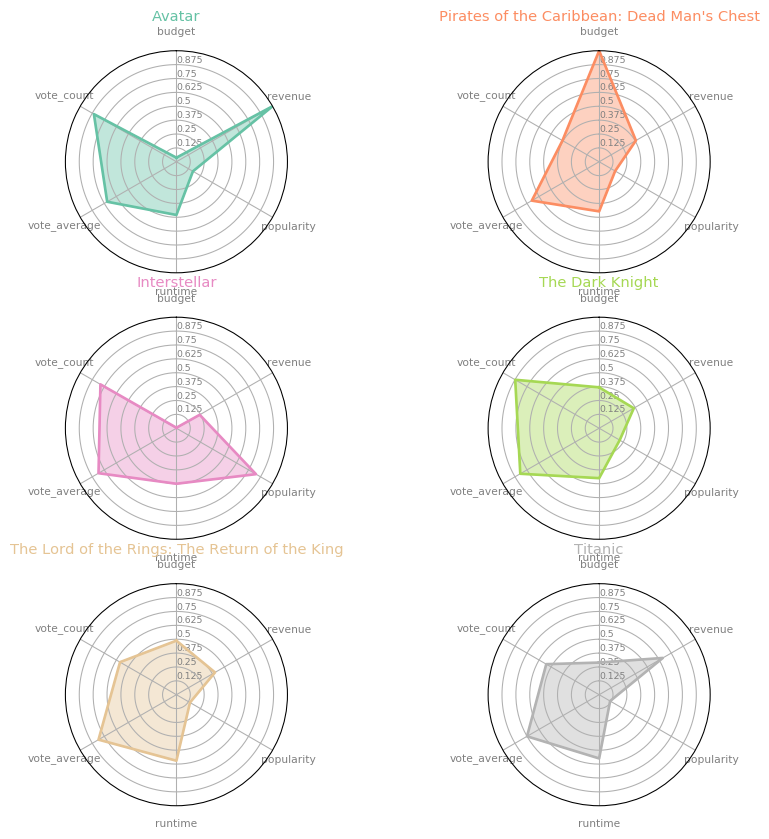

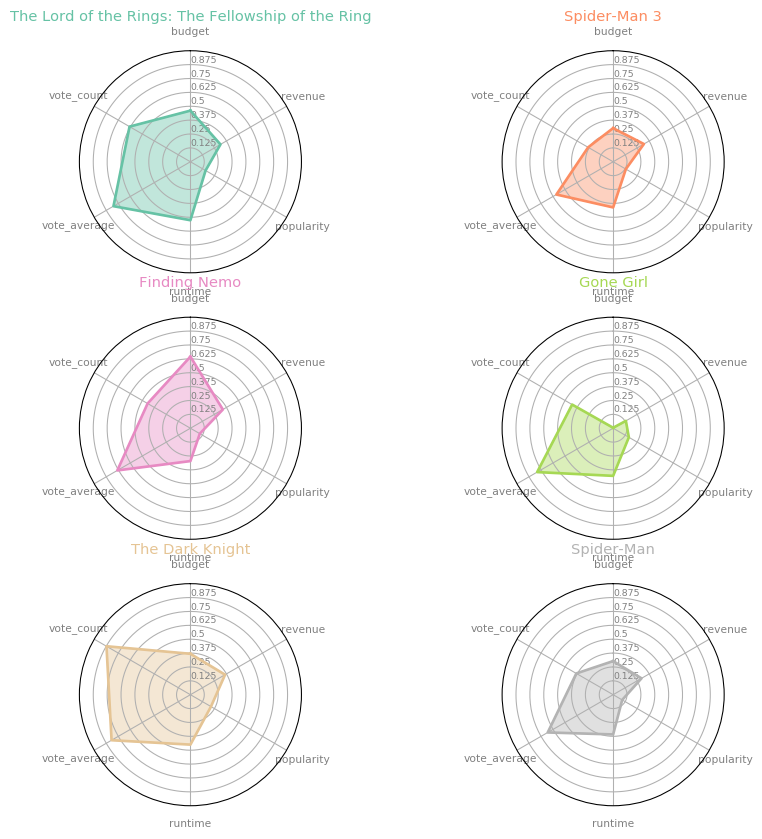

In [17]:
radarAllPlot(df.sort_values(by=['wa'],ascending=False).head(6),indices)
radarAllPlot(df.sort_values(by=['minVal'],ascending=False).head(6),indices)

data = df.values[:,indices]

### Entrenamiento

In [18]:
# Entrenamiento
KM.train(data)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	237	238	239	240	241	242	243	244	245	246	247	248	249	0.06233539967152693


### Reduccion Dimencional

In [19]:
pca = PCA()
reducedD1 = pca.execute(df[df.columns[indices]].fillna(0).values,5)
df[['PCA1','PCA2','PCA3']] = pd.DataFrame(np.dot(df[df.columns[indices]].fillna(0).values,reducedD1))
df = weightedAverage(df,pesos,PCAindices,n='PCAWA')

### Agrupamiento de datos Multi-dimencionales + Entrenamiento2

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	237	238	239	240	241	242	243	244	245	246	247	248	249	0.11674760526719548


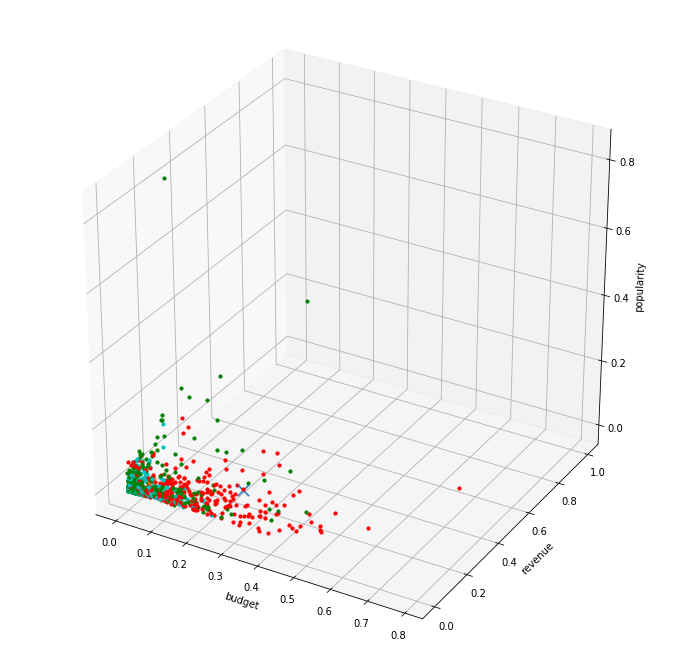

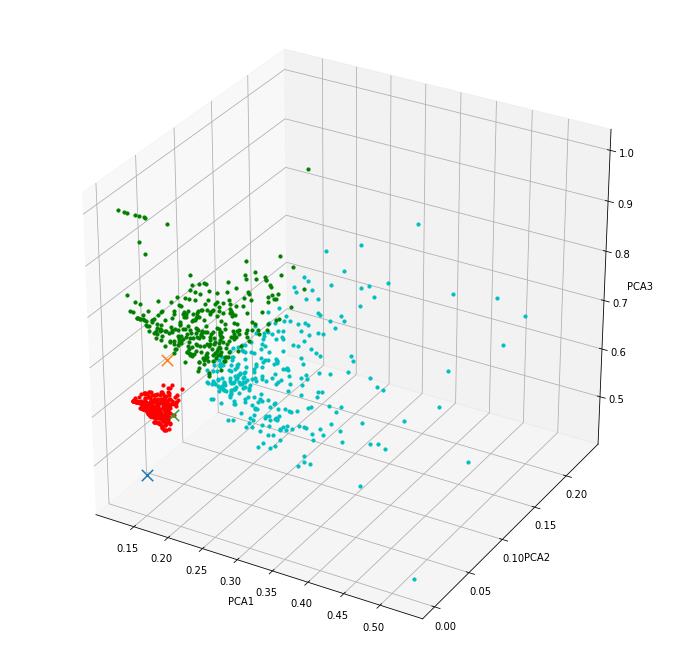

In [20]:
KM2=K_Means(3)
data = df.values[:,PCAindices]
KM2.train(data)

KM.plot3D(labels=('budget','revenue','popularity'))
KM2.plot3D()

# GUI

In [21]:
import dfgui
dfgui.show(df)
dfgui.show(dfSky)

D:\Anaconda\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Anaconda\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
